In [37]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import ehtim as eh

from torchvision.transforms import v2
import data.dataset as ds
import data.CI as CI
import torchvision
import model_AttnAE as mlmodel
import os
from tqdm.auto import tqdm

import glob

from xlogger import *

# use gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_name = 'AttnAE'
append = True
train_logger = xlogger('models/history/' + model_name + '_train.dat', append=append)
val_logger = xlogger('models/history/' + model_name + '_val.dat', append=append)


In [38]:
# plot all images in the batch
def plot_images(images, save=False, name='images'):
    fig, axes = plt.subplots(2, len(images)//2, figsize=(len(images)//2*0.99, 2))
    fig.subplots_adjust(hspace=0., wspace=0.)
    axes = axes.flatten()
    for ax, img in zip(axes, images):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
    if save:
        direc = 'models/history/'+name+'/'
        os.makedirs(direc, exist_ok=True)
        # check next number
        num = 0
        while glob.glob(f'{direc}{name}_{num}.png'):
            num += 1
        plt.savefig(f'{direc}{name}_{num}.png')

    plt.show()

def log_avgLoss(data, logger):
    # log the avg loss given array of all epochs
    data = np.sum(np.transpose(data), axis=1)/len(data)
    kwargs = {'features_loss': data[0],
              'class_loss': data[1],
              'encoder_corr': data[2],
              'pred_corr': data[3],
              'weighted_loss': data[4]}
    logger.write(kwargs)
    return data
    


def nxcorr(outputs, labels):
    dim = int(outputs.shape[-1])
    outputs = outputs.reshape(-1, dim**2)
    labels = labels.reshape(-1, dim**2)
    
    outputs_norm = (outputs.reshape(-1, dim, dim) - torch.nanmean(outputs, axis=1).reshape(-1, 1, 1)) / torch.std(outputs, axis=1).reshape(-1, 1, 1)
    labels_norm = (labels.reshape(-1, dim, dim) - torch.nanmean(labels, axis=1).reshape(-1, 1, 1)) / torch.std(labels, axis=1).reshape(-1, 1, 1)

    fft_outputs = torch.fft.fftn(outputs_norm, dim=[1,2])
    fft_labels = torch.fft.fftn(labels_norm, dim=[1,2])

    xcorr = torch.fft.ifftn(fft_outputs * torch.conj(fft_labels), dim=[1,2])

    nxcorr_flat = xcorr.reshape(-1, dim**2)
    idx = torch.argmax(torch.abs(nxcorr_flat), dim=1)

    return idx, torch.abs(nxcorr_flat[torch.arange(nxcorr_flat.shape[0]), idx])/dim**2

def shift_image(im1, im2): # shift single im2 by idx
    idx, _ = nxcorr(im1, im2)
    im2 = torch.roll(im2, shifts=int(idx))
    return im1, im2

def nxcorr_loss(outputs, labels): # assume square images
    _, xcorr = nxcorr(outputs, labels)
    loss_mean = torch.nanmean(1-xcorr)
    return loss_mean

def nxcorr_network_loss(out_img, label_img):
    # normalise outputs and labels
    # outputs = (outputs - torch.mean(outputs, axis=1).reshape(-1, 1)) / torch.std(outputs, axis=1).reshape(-1, 1)
    # labels = (labels - torch.mean(labels, axis=1).reshape(-1, 1)) / torch.std(labels, axis=1).reshape(-1, 1)
    power = 1.0
    mseloss = nn.MSELoss()
    mse_weight = 0.9
    mseloss_val = mseloss(out_img, label_img**power)
    nxcorr_val = nxcorr_loss(out_img, label_img**power)
    return mse_weight*mseloss_val + nxcorr_val*(1-mse_weight)


mseloss = nn.MSELoss()
ce_loss = nn.CrossEntropyLoss()
loss_weights = torch.tensor([1, 0.03, 2.0, 3.0])

def total_loss(outputs, input_imgs, classes, weights=torch.tensor([1., 1., 1., 1.]), print_loss=False, logger=None):
    features_vae, features_q, features_ci, recon_img, pred_img, pred_class = outputs
    # features_vae = features_vae.view(features_vae.shape[0], -1)
    # features_ci = features_ci.view(features_ci.shape[0], -1)
    
    features_loss = mseloss(features_ci, features_q)

    class_loss = ce_loss(pred_class, classes)
    
    # first channel only
    recon_img = recon_img[:,0]
    pred_img = pred_img[:,0]
    input_imgs = input_imgs[:,0]
    encoder_corr = nxcorr_network_loss(recon_img, input_imgs)
    pred_corr = nxcorr_network_loss(pred_img, input_imgs)


    total = weights[0]*features_loss + weights[1]*class_loss + weights[2]*encoder_corr + weights[3]*pred_corr

    losses_individual = [features_loss.cpu().detach(), 
                         class_loss.cpu().detach(), 
                         encoder_corr.cpu().detach(), 
                         pred_corr.cpu().detach(), 
                         total.cpu().detach()]
    losses_weighted = np.array([weights[i].cpu().detach()*losses_individual[i].cpu().detach() for i in range(len(weights))] + [total.cpu().detach()])
    
    if print_loss:
        print(f'features_loss: {features_loss}, class_loss: {class_loss}, encoder_corr: {encoder_corr}, pred_corr: {pred_corr}')
    if logger:
        kwargs = {'features_loss': features_loss.cpu().detach().numpy(), 
                  'class_loss': class_loss.cpu().detach().numpy(), 
                  'encoder_corr': encoder_corr.cpu().detach().numpy(), 
                  'pred_corr': pred_corr.cpu().detach().numpy(),
                  'weighted_loss': total.cpu().detach().numpy()}
        logger.write(kwargs)
        

    return total, losses_individual, losses_weighted

In [39]:
def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = 0.01
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

train_transforms = v2.Compose([
    v2.ToTensor(),
    # gauss_noise_tensor,
    v2.RandomHorizontalFlip(),
    v2.RandomVerticalFlip(),
    v2.RandomRotation(90, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
    v2.GaussianBlur(3, sigma=(0.1, 0.5)),
    v2.CenterCrop(64),
])

val_transforms = v2.Compose([
    v2.ToTensor(),
    v2.CenterCrop(64),
])

In [40]:
load = True

# initialise weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

if load:
    model = torch.load('models/'+model_name+'.pt').to(device)
else: 
    model = mlmodel.Vae_FD(latent_size=4, k_classes=7).to(device)
    model.apply(weights_init)


Loading text image:  ./data/template_sgra.txt
Loading text image:  ./data/template_sgra.txt
Img Shape: torch.Size([1, 64, 64])
CI Shape: torch.Size([992])
Class Shape: torch.Size([7])

Img Data Shape: torch.Size([32, 1, 64, 64])
CI Data Shape: torch.Size([32, 992])
Class Data Shape: torch.Size([32, 7])


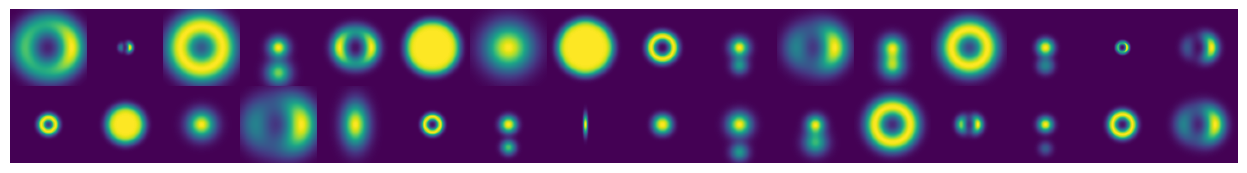

In [41]:
batch_size = 32


data_dir = 'data/datasets/v3/'
mnames = ['gauss', 'disk', 'ellipse', 'ring', 'mring', 'disk2', 'gauss2']

filenames = np.array([data_dir + 'train/train_' + m + '.npy' for m in mnames])
train_data = ds.ImgDataset(filenames, transform=train_transforms, ehtim=True, tint_sec=5, tadv_sec=600, tstart_hr=0, tstop_hr=24)

filenames = np.array([data_dir + 'val/val_' + m + '.npy' for m in mnames])
val_data = ds.ImgDataset(filenames, transform=val_transforms, ehtim=True, tint_sec=5, tadv_sec=600, tstart_hr=0, tstop_hr=24)

print('Img Shape:', train_data[0][0].shape)
print('CI Shape:', train_data[0][1].shape)
print('Class Shape:', train_data[0][2].shape)

train = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val = DataLoader(val_data, batch_size=batch_size, shuffle=True)

dataiter = iter(train)
data = next(dataiter)

print()

print('Img Data Shape:', data[0].shape)
print('CI Data Shape:', data[1].shape)
print('Class Data Shape:', data[2].shape)  


# single validation batch
dataiter = iter(val)
static_val = next(dataiter)

plot_images(static_val[0])





In [42]:
# Check out the loss

criterion = total_loss
i = 0 
for i, data in enumerate(train, 0):
    imgs, ci, cls = data
    imgs, ci, cls = imgs.to(device), ci.to(device), cls.to(device)
    outputs = model(imgs, ci)
    loss, _, _ = criterion(outputs, imgs, cls, print_loss=True, weights=loss_weights, logger=None)
    i += 1

    print(outputs[0].shape, outputs[1].shape, outputs[2].shape, outputs[3].shape, outputs[4].shape)

    print('loss:', loss)

    if i > 0:
        break


features_loss: 0.00013178656809031963, class_loss: 1.1654224395751953, encoder_corr: 0.0002332929871045053, pred_corr: 0.0007715282845310867
torch.Size([32, 4, 16, 16]) torch.Size([32, 4, 16, 16]) torch.Size([32, 4, 16, 16]) torch.Size([32, 1, 64, 64]) torch.Size([32, 1, 64, 64])
loss: tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
min_val_loss = np.inf

In [ ]:
nepochs = 30
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = total_loss
l1 = lambda epoch: 0.98 ** epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=l1)

for epoch in range(nepochs):
    model.train()
    train_loss = []
    for data in tqdm(train):
        imgs, ci, cls  = data
        imgs, ci, cls = imgs.to(device), ci.to(device), cls.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, ci)
        loss, loss_individual, loss_weighted = criterion(outputs, imgs, cls, loss_weights, logger=None)
        loss.backward()
        optimizer.step()
        train_loss.append(loss_weighted)
    train_loss = log_avgLoss(train_loss, train_logger)
    model.eval()
    val_loss = []
    for data in val:
        imgs, ci, cls  = data
        imgs, ci, cls = imgs.to(device), ci.to(device), cls.to(device)
        outputs = model(imgs, ci)
        loss, loss_individual, loss_weighted = criterion(outputs, imgs, cls, loss_weights, logger=None)
        val_loss.append(loss_weighted)
    val_loss = log_avgLoss(val_loss, val_logger)

    if val_loss[-1] < min_val_loss: # save model
        min_val_loss = val_loss[-1]
        torch.save(model, 'models/'+model_name+'.pt')
    # save checkpoint
    if epoch % 10 == 0:
        torch.save(model, 'models/'+model_name+'_'+str(epoch)+'.pt')

    # plot images in the last batch every 5 epochs
    if epoch % 5 == 0:
        imgs, ci, cls = static_val
        features_vae, features_q, features_ci, recon_img, pred_img, pred_class = model(imgs.to(device), ci.to(device))
        plot_images(imgs.cpu().detach())
        plot_images(recon_img.cpu().detach()) 
        plot_images(pred_img.cpu().detach(), save=False, name=model_name) 
        
    print(f'Epoch {epoch+1}, Train loss: {train_loss[-1]}, Val loss: {val_loss[-1]}, lr: {scheduler.get_last_lr()[0]}')
    scheduler.step()
    

In [ ]:
# plot loss history

train_loss = read_xlogfile('models/history/'+model_name+'_train.dat')
val_loss = read_xlogfile('models/history/'+model_name+'_val.dat')

l_weights = loss_weights.numpy()

fig, ax = plt.subplots(1,2, figsize=(10,5))
plot_from = 0
ax[0].plot(train_loss['weighted_loss'][plot_from:], label='Weighted')
ax[0].plot(l_weights[0]*train_loss['features_loss'][plot_from:], label='Features')
ax[0].plot(l_weights[1]*train_loss['class_loss'][plot_from:], label='Class')
ax[0].plot(l_weights[2]*train_loss['encoder_corr'][plot_from:], label='Encoder')
ax[0].plot(l_weights[3]*train_loss['pred_corr'][plot_from:], label='Prediction')

plot_from = 0
ax[1].plot(val_loss['weighted_loss'][plot_from:], label='Weighted')
ax[1].plot(l_weights[0]*val_loss['features_loss'][plot_from:], label='Features')
ax[1].plot(l_weights[1]*val_loss['class_loss'][plot_from:], label='Class')
ax[1].plot(l_weights[2]*val_loss['encoder_corr'][plot_from:], label='Encoder')
ax[1].plot(l_weights[3]*val_loss['pred_corr'][plot_from:], label='Prediction')

ax[0].legend()
ax[1].legend()



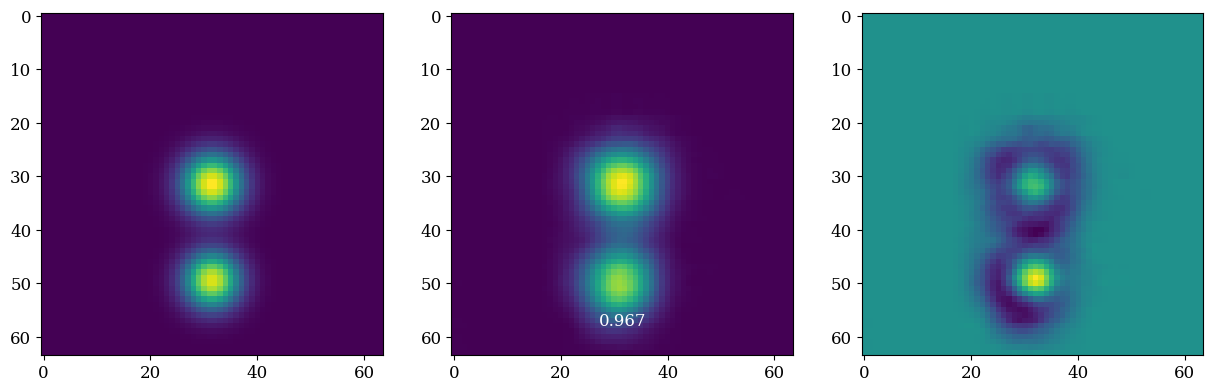

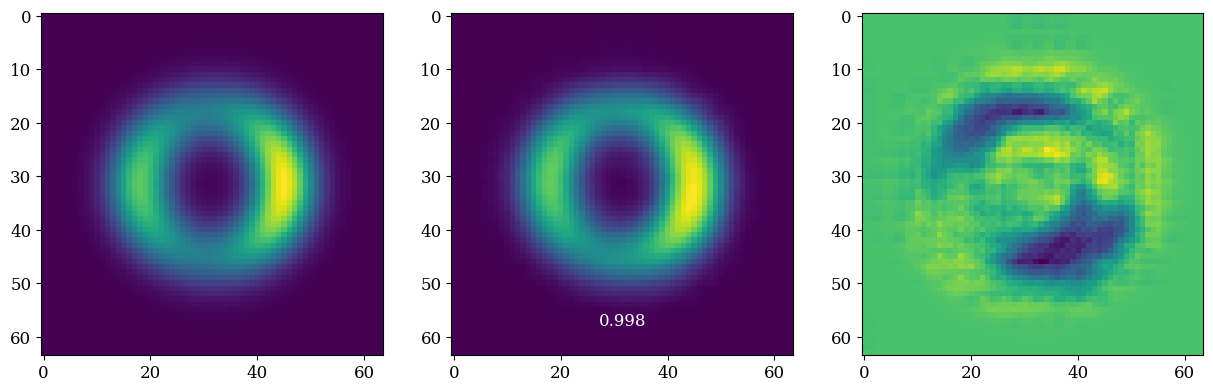

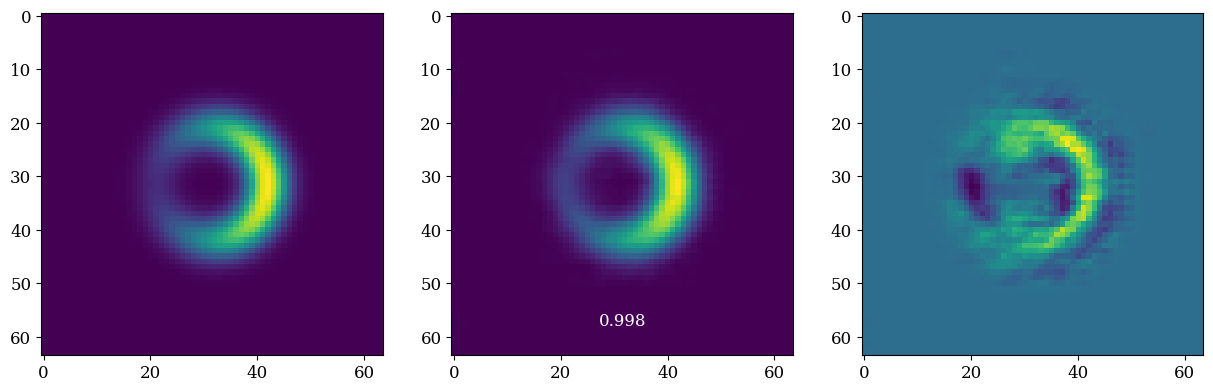

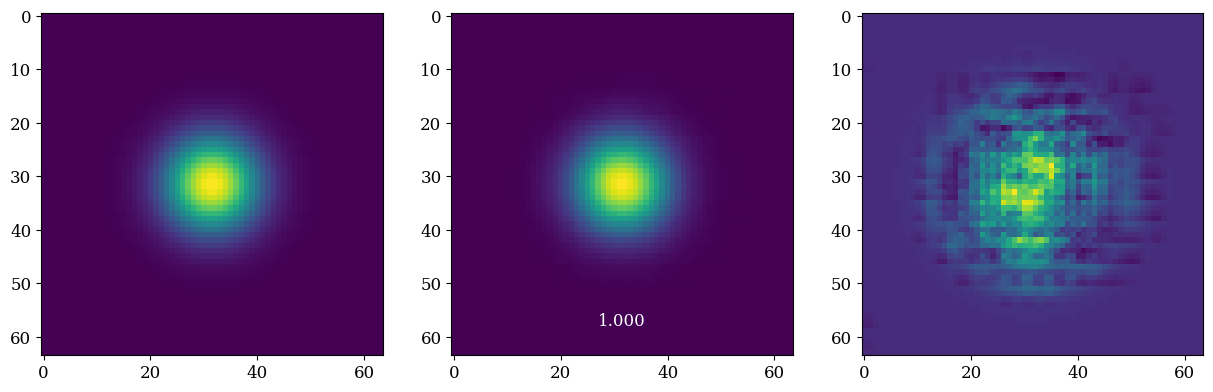

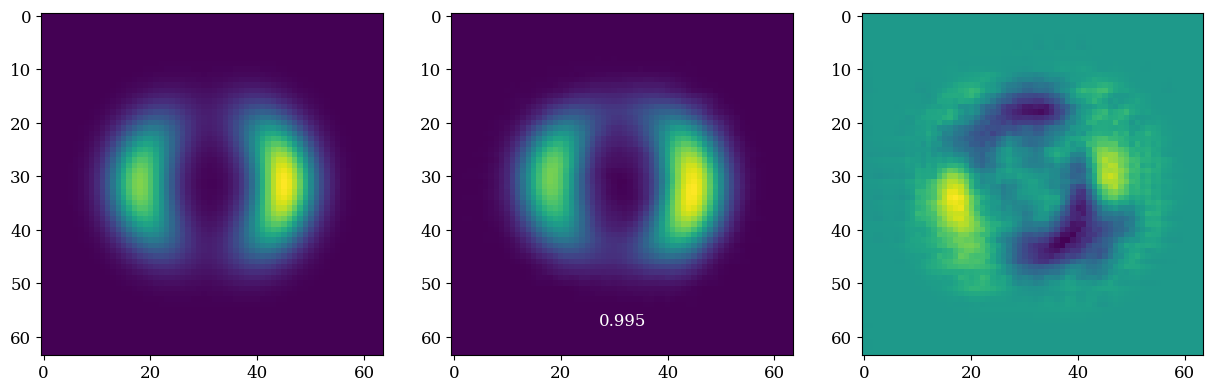

In [44]:
# test the model
test = DataLoader(val_data, batch_size=1, shuffle=True)
for i, data in enumerate(test, 0):
    if i >= 5:
        break
    img, ci, cls = data
    img, ci, cls = img.to(device), ci.to(device), cls.to(device)
    outputs = model(img, ci)
    features_vae, features_q, features_ci, recon_img, pred_img, pred_class = outputs
    fig, ax = plt.subplots(1, 3, figsize=(15,5))
    img = img.cpu().detach().numpy()[0][0]
    pred_img = pred_img.cpu().detach().numpy()[0][0]
    ax[0].imshow(img)
    ax[1].imshow(pred_img)
    xcorr = nxcorr(torch.Tensor(img), torch.Tensor(pred_img))[1].cpu().detach().numpy()[0]
    ax[1].text(0.5, 0.1, f'{xcorr:.3f}', ha='center', va='center', transform=ax[1].transAxes, color='white')
    ax[2].imshow((img-pred_img))



Loading fits image:  /home/lai075/GitHub/CI_ImRec/Images/ring.fits
Loading text image:  ./data/template_sgra.txt
mring


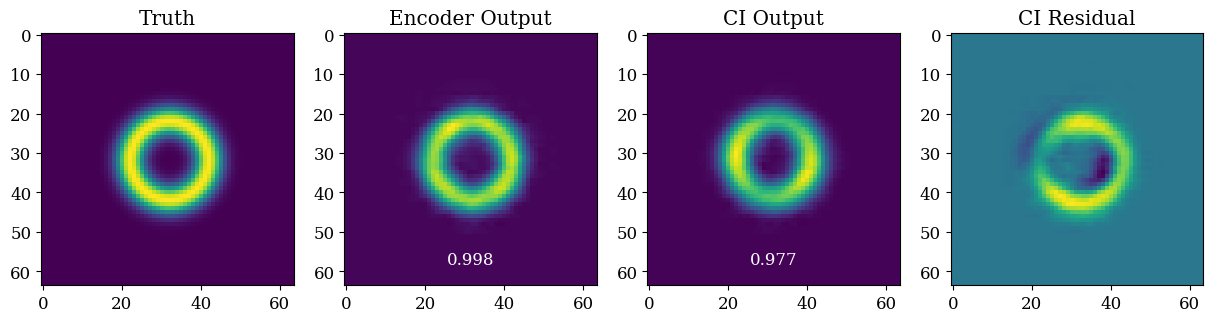

In [50]:
# test with custom image
imgdim = 64

model = torch.load('models/'+model_name+'.pt')
# model = torch.load('models/ae_mlp_300524.pt')

load_fits = '/home/lai075/GitHub/CI_ImRec/Images/ring.fits'

img = eh.image.load_fits(load_fits)

name = load_fits.split('/')[-1].split('.')[0]

im = img.regrid_image(img.fovx(), imgdim)
im = im.imarr()

im = im/np.max(im) # normalise the intensity

im = val_transforms(im)
im = im.to(torch.float32)

Closure = CI.Closure_Invariants('data/ehtuv.npz', ehtarray='./data/EHT2017.txt', ehtim=True, tint_sec=5, tadv_sec=600, tstart_hr=0, tstop_hr=24)
invs = Closure.FTCI(np.array([im])).reshape(-1)

invs = torch.Tensor(invs).reshape(1, -1)
invs = invs.to(device)

outputs = model.predict(invs)
outputs = outputs[1].cpu().detach().numpy().reshape(imgdim,imgdim)

power = 1.

# im, outputs = shift_image(torch.Tensor(im), torch.Tensor(outputs)**(1./power))
im, outputs = im.reshape(imgdim, imgdim), outputs.reshape(imgdim, imgdim)#.numpy()

_, _, encoder_out = model.encoder_to_img(torch.Tensor(im).view(1,1,imgdim, imgdim).to(device))
encoder_out = encoder_out.cpu().detach().numpy().reshape(imgdim, imgdim)


fig, ax = plt.subplots(1, 4, figsize=(15,5))
ax[0].imshow(im)
ax[0].set_title('Truth')


ax[1].imshow(encoder_out)
ax[1].set_title('Encoder Output')
idx, xcorr = nxcorr(torch.Tensor(encoder_out), torch.Tensor(im)**(1./power))
xcorr = xcorr.cpu().detach().numpy()[0]
ax[1].text(0.5, 0.1, f'{xcorr:.3f}', ha='center', va='center', transform=ax[1].transAxes, color='white')

# flip 
# outputs = torch.Tensor(outputs)
# outputs = torch.flip(outputs, [0,1])
# outputs = outputs.cpu().detach().numpy()

ax[2].imshow(outputs)
ax[2].set_title('CI Output')
idx, xcorr = nxcorr(torch.Tensor(outputs), torch.Tensor(im)**(1./power))
xcorr = xcorr.cpu().detach().numpy()[0]
ax[2].text(0.5, 0.1, f'{xcorr:.3f}', ha='center', va='center', transform=ax[2].transAxes, color='white')


ax[3].imshow(im-outputs)
ax[3].set_title('CI Residual')


# predict class
cls_pred = model.predict_class(invs).cpu().detach().numpy()
cls_pred = mnames[np.argmax(cls_pred)]
print(cls_pred)

output = img.copy().regrid_image(img.fovx(), 64)
output._imdict['I'] = outputs


# output.save_fits('results/ML-image/'+name+'.fits')
